ZZ Feature Map Algorithm 1 test

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError


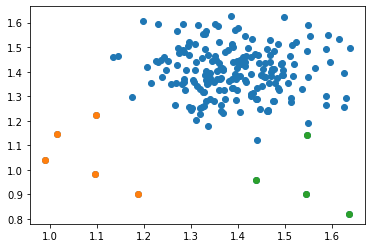

In [2]:
random.seed(13)
seed = 0
x, y = make_blobs(n_samples=200, centers=1, cluster_std=.1, center_box=(1.4, 1.4), random_state=seed)

out1x, out1y = make_blobs(n_samples=5, centers=1, cluster_std=.1, center_box=(1, 1), random_state=seed)
out2x, out2y = make_blobs(n_samples=4, centers=1, cluster_std=.1, center_box=(3.2, 0.01), random_state=seed)

# anom_index = where(pred==-1)
# values = x[anom_index]

# plt.scatter(values[:,0], values[:,1], color='r')

plt.show()
# Test train split data
y[y == 0] = 1
out1y[out1y==0] = -1 
out2y[out2y==0] = -1 

x = np.append(x, out1x, axis = 0)
y = np.append(y, out1y, axis = 0)

x = np.append(x, out2x, axis = 0)
y = np.append(y, out2y, axis = 0)
# print(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.001, random_state=seed)
# plt.scatter(x[:,0], x[:,1], color='b')
plt.scatter(x[:,0], x[:,1])
plt.scatter(out1x[:,0], out1x[:,1])
plt.scatter(out2x[:,0], out2x[:,1])

plt.show()

Kernel

In [3]:
Qseed = 0
num_features = len(x[0])
Feature_map = ZZFeatureMap(feature_dimension = num_features, reps = 1, entanglement="linear")
backend = BasicAer.get_backend("qasm_simulator")
simulator = QuantumInstance(backend, shots=5, seed_simulator=Qseed, seed_transpiler=Qseed)
waveform_kernel = QuantumKernel(feature_map=Feature_map, quantum_instance=simulator)

Precomputation of data

In [4]:
precomp_kernel = waveform_kernel.evaluate(x)
precomp_kernel_real = np.real(precomp_kernel)
outliers_fraction = 9/200
svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)

# fit data to OneClassSVM
svm.fit(precomp_kernel_real)

[LibSVM]

OneClassSVM(kernel='precomputed', nu=0.045, verbose=True)

Prediction

In [5]:
# Precomp is from X_train, so use X_train as plot device
y_pred = svm.predict(precomp_kernel_real)
print(accuracy_score(y, y_pred))

print(y)
print(y_pred)


0.9473684210526315
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1 

In [6]:
svm_classical = OneClassSVM(kernel = 'rbf', verbose=True,  nu=outliers_fraction)
svm_classical.fit(X_train)

y_pred = svm_classical.predict(X_train)
print("RBF: ")
print(accuracy_score(y_train, y_pred))

print(y_train)
print(y_pred)

#############################
svm_classical = OneClassSVM(kernel = 'linear', verbose=True,  nu=outliers_fraction)
svm_classical.fit(X_train)

y_pred = svm_classical.predict(X_train)
print("Linear: ")
print(accuracy_score(y_train, y_pred))

print(y_train)
print(y_pred)



#############################
svm_classical = OneClassSVM(kernel = 'poly', verbose=True,  nu=outliers_fraction)
svm_classical.fit(X_train)

y_pred = svm_classical.predict(X_train)
print("Poly: ")
print(accuracy_score(y_train, y_pred))

print(y_train)
print(y_pred)


#############################
svm_classical = OneClassSVM(kernel = 'sigmoid', verbose=True,  nu=outliers_fraction)
svm_classical.fit(X_train)

y_pred = svm_classical.predict(X_train)
print("Sigmoid: ")
print(accuracy_score(y_train, y_pred))

print(y_train)
print(y_pred)

[LibSVM]RBF: 
0.9182692307692307
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1
  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1 -1 -1  1  1  1  1  1  1  

Second algorithm attempt

In [7]:
Qseed = 0
num_features = len(x[0])
backend = BasicAer.get_backend("qasm_simulator")
simulator = QuantumInstance(backend, shots=5, seed_simulator=Qseed, seed_transpiler=Qseed)
waveform_kernel = FidelityQuantumKernel()
precomp_kernel = waveform_kernel.evaluate(x)
precomp_kernel_real = np.real(precomp_kernel)
outliers_fraction = 9/200
svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)

# fit data to OneClassSVM
svm.fit(precomp_kernel_real)

[LibSVM]

OneClassSVM(kernel='precomputed', nu=0.045, verbose=True)

In [8]:
y_pred = svm.predict(precomp_kernel_real)
print(accuracy_score(y, y_pred))

print(y)
print(y_pred)

0.9617224880382775
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

In [1]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"


def QuantumOneClassSVM(nu, gamma):
    precomp_kernel = waveform_kernel.evaluate(X_train)
    precomp_kernel_real = np.real(precomp_kernel)
    svm = OneClassSVM(kernel = 'precomputed', verbose=True)
    # fit data to OneClassSVM
    svm.fit(precomp_kernel_real)

In [9]:


Qseed = 0
num_features = len(x[0])
adhoc_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

In [10]:
precomp_kernel = adhoc_kernel.evaluate(x)
precomp_kernel_real = np.real(precomp_kernel)
outliers_fraction = 9/200
svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)

# fit data to OneClassSVM
svm.fit(precomp_kernel_real)

[LibSVM]

OneClassSVM(kernel='precomputed', nu=0.045, verbose=True)

In [12]:
y_pred = svm.predict(precomp_kernel_real)
print(accuracy_score(y, y_pred))

print(y)
print(y_pred)

0.9617224880382775
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[LibSVM][LibSVM]

KeyboardInterrupt: 

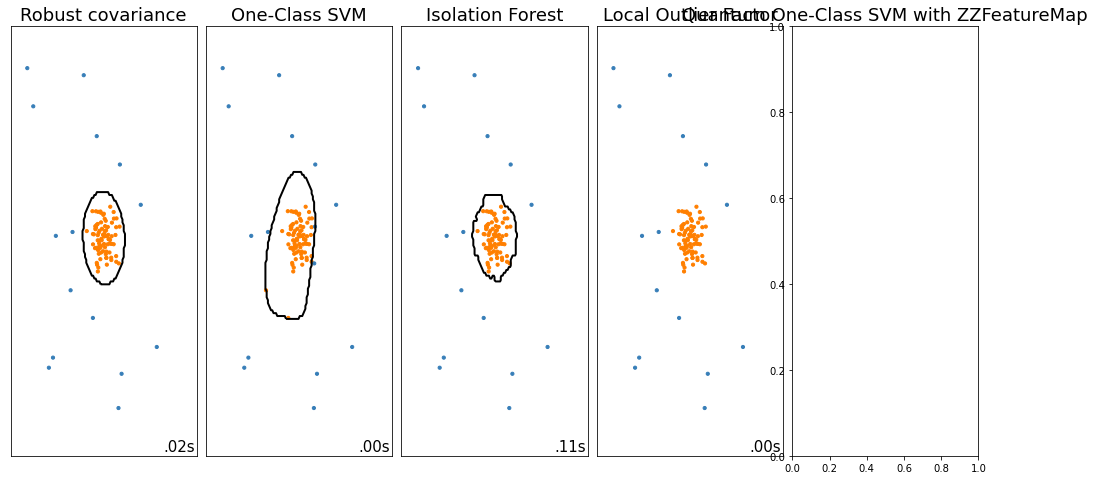

In [9]:
# n_samples = 100
# outliers_fraction = 0.15
# n_outliers = int(outliers_fraction * n_samples)
# n_inliers = n_samples - n_outliers
# accuracy_list = []
# # define outlier/anomaly detection methods to be compared.
# anomaly_algorithms = [
#     ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
#     ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
#     (
#         "Isolation Forest",
#         IsolationForest(contamination=outliers_fraction, random_state=42),
#     ),
#     (
#         "Local Outlier Factor",
#         LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
#     ),
#     ("Quantum One-Class SVM with ZZFeatureMap", QuantumOneClassSVM(nu=outliers_fraction, gamma=0.1)),
# ]

# # Define datasets
# blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
# datasets = [
#     make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
#     make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
#     make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
#     4.0
#     * (
#         make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
#         - np.array([0.5, 0.25])
#     ),
#     14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
# ]

# # Compare given classifiers under given settings
# xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

# plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
# plt.subplots_adjust(
#     left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
# )

# plot_num = 1
# rng = np.random.RandomState(42)

# for i_dataset, X in enumerate(datasets):
#     # Add outliers
#     X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

#     for name, algorithm in anomaly_algorithms:
#         t0 = time.time()
#         if name == "Quantum One-Class SVM with ZZFeatureMap":
#             Qseed = 0
#             num_features = len(X[0])
#             Feature_map = ZZFeatureMap(feature_dimension = num_features, reps = 1, entanglement="full")
#             backend = BasicAer.get_backend("qasm_simulator")
#             simulator = QuantumInstance(backend, shots=1, seed_simulator=Qseed, seed_transpiler=Qseed)
#             waveform_kernel = QuantumKernel(feature_map=Feature_map, quantum_instance=simulator)
#             precomp_kernel = waveform_kernel.evaluate(X)
#             precomp_kernel_real = np.real(precomp_kernel)
#             qsvm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction, gamma=0.1)
#             qsvm.fit(precomp_kernel_real)
#         else:
#             algorithm.fit(X)
#         t1 = time.time()
#         plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
#         if i_dataset == 0:
#             plt.title(name, size=18)

#         # fit the data and tag outliers
#         if name == "Local Outlier Factor":
#             y_pred = algorithm.fit_predict(X)
#         elif name == "Quantum One-Class SVM with ZZFeatureMap":
#             y_pred = qsvm.predict(precomp_kernel_real)
#         else:
#             y_pred = algorithm.fit(X).predict(X)
#         # plot the levels lines and the points
#         if name != "Local Outlier Factor" and name != "Quantum One-Class SVM with ZZFeatureMap":  # LOF does not implement predict
#             Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
#             Z = Z.reshape(xx.shape)
#             plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
# #         if name == "Quantum One-Class SVM with ZZFeatureMap":
# #             dataforpredict = waveform_kernel.evaluate(np.c_[xx.ravel(), yy.ravel()])
# #             dataforpredict_real = np.real(dataforpredict)
# #             Z = qsvm.predict(dataforpredict_real)
# #             Z = Z.reshape(xx.shape)
# #             plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
            
#         colors = np.array(["#377eb8", "#ff7f00"])
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

#         plt.xlim(-7, 7)
#         plt.ylim(-7, 7)
#         plt.xticks(())
#         plt.yticks(())
#         plt.text(
#             0.99,
#             0.01,
#             ("%.2fs" % (t1 - t0)).lstrip("0"),
#             transform=plt.gca().transAxes,
#             size=15,
#             horizontalalignment="right",
#         )
#         plot_num += 1

# plt.show()